In [88]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

# Фиксируем random seed для воспроизводимости
np.random.seed(42)


In [89]:
@dataclass
class LIFNeuron:
    tau_m: float = 10.0     # Постоянная времени мембраны (мс)
    v_rest: float = -65.0   # Потенциал покоя (мВ)
    v_thresh: float = -55.0 # Порог (мВ)
    v_reset: float = -70.0  # Потенциал сброса (мВ)
    r_m: float = 20.0       # Мембранное сопротивление (МОм)
    tau_ref: float = 2.0    # Рефрактерный период (мс)

    def __post_init__(self):
        self.reset()

    def reset(self):
        """Сброс состояния нейрона."""
        self.v = self.v_rest
        self.refractory_until = 0.0
        self.spike_times = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        """Один шаг интегрирования. Возвращает True, если был спайк."""

        # Рефрактерный период
        if t < self.refractory_until:
            self.v = self.v_reset
            return False

        # Уравнение LIF (метод Эйлера)
        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt

        # Проверка порога
        if self.v >= self.v_thresh:
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True

        return False


def simulate_neuron(neuron: LIFNeuron,
                    I_inj: np.ndarray,
                    t_range: np.ndarray,
                    dt: float) -> Tuple[List[float], List[float]]:
    """
    Запуск симуляции одного нейрона.
    Возвращает:
        v_trace – история потенциала
        spike_times – времена спайков
    """
    neuron.reset()

    v_trace = []
    spike_times = []

    for i, t in enumerate(t_range):
        spike = neuron.step(I_inj[i], dt, t)
        v_trace.append(neuron.v)
        if spike:
            spike_times.append(t)

    return v_trace, spike_times


def plot_neuron_activity(t_range: np.ndarray,
                         v_trace: List[float],
                         spike_times: List[float],
                         v_thresh: float,
                         v_rest: float):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax1.plot(t_range, v_trace)
    ax1.axhline(y=v_thresh, linestyle='--')
    ax1.axhline(y=v_rest, linestyle='--')
    ax1.set_ylabel("Мембранный потенциал (мВ)")
    ax1.grid(True)

    ax2.eventplot(spike_times)
    ax2.set_xlabel("Время (мс)")
    ax2.set_yticks([])
    ax2.set_ylabel("Спайки")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [90]:
class SNNLayer:
    def __init__(self, n_inputs: int, n_neurons: int):

        self.n_inputs = n_inputs
        self.n_neurons = n_neurons

        # Более сильные веса
        self.weights = np.random.uniform(
            low=5.0,
            high=10.0,
            size=(n_neurons, n_inputs)
        )

        self.w_min = 0.0
        self.w_max = 15.0

        self.neurons = [LIFNeuron() for _ in range(n_neurons)]

        # ===== СИНАПТИЧЕСКАЯ ДИНАМИКА =====
        self.tau_syn = 5.0
        self.syn_current = np.zeros(n_neurons)

        # ===== STDP =====
        self.A_plus = 0.02
        self.A_minus = 0.025
        self.tau_plus = 20.0
        self.tau_minus = 20.0

        self.last_pre_spike = np.full(n_inputs, -np.inf)

    def reset(self):
        for neuron in self.neurons:
            neuron.reset()

        self.syn_current[:] = 0.0
        self.last_pre_spike[:] = -np.inf

    def stdp_update(self, post_neuron_id: int, t_post: float):

        for i in range(self.n_inputs):

            t_pre = self.last_pre_spike[i]
            if t_pre == -np.inf:
                continue

            delta_t = t_post - t_pre

            if delta_t > 0:
                dw = self.A_plus * np.exp(-delta_t / self.tau_plus)
            else:
                dw = -self.A_minus * np.exp(delta_t / self.tau_minus)

            self.weights[post_neuron_id, i] += dw

        self.weights = np.clip(self.weights,
                               self.w_min,
                               self.w_max)

    def step(self, input_spikes: np.ndarray, dt: float, t: float):
        output_spikes = np.zeros(self.n_neurons)

        for i in range(self.n_inputs):
            if input_spikes[i] == 1:
                self.last_pre_spike[i] = t

        self.syn_current *= np.exp(-dt / self.tau_syn)
        
        # Добавляем входной ток
        for j in range(self.n_neurons):
            self.syn_current[j] += np.dot(self.weights[j], input_spikes)

        # Обработка нейронов
        for j, neuron in enumerate(self.neurons):
            spike = neuron.step(self.syn_current[j], dt, t)

            if spike:
                output_spikes[j] = 1.0
                self.stdp_update(j, t)
                
                # --- МЕХАНИЗМ КОНКУРЕНЦИИ (WTA) ---
                # Если этот нейрон выдал спайк, он тормозит остальных
                for other_j in range(self.n_neurons):
                    if other_j != j:
                        self.neurons[other_j].v = -80.0 # Глубокое торможение
        return output_spikes
    
def poisson_encoding(rate: float, dt: float) -> int:
    """
    Генерирует 0 или 1 (спайк) с вероятностью rate * dt
    """
    return np.random.rand() < rate * dt
    
    
    


In [91]:

def simulate_network(layer: SNNLayer,
                     input_rates: np.ndarray,
                     T: float,
                     dt: float):

    t_range = np.arange(0, T, dt)

    layer.reset()

    spike_record = [[] for _ in range(layer.n_neurons)]
    weight_history = []

    for t in t_range:

        input_spikes = np.array([
            poisson_encoding(rate, dt)
            for rate in input_rates
        ])

        output_spikes = layer.step(input_spikes, dt, t)

        weight_history.append(layer.weights.copy())

        for j in range(layer.n_neurons):
            if output_spikes[j] == 1:
                spike_record[j].append(t)

    return spike_record, np.array(weight_history)

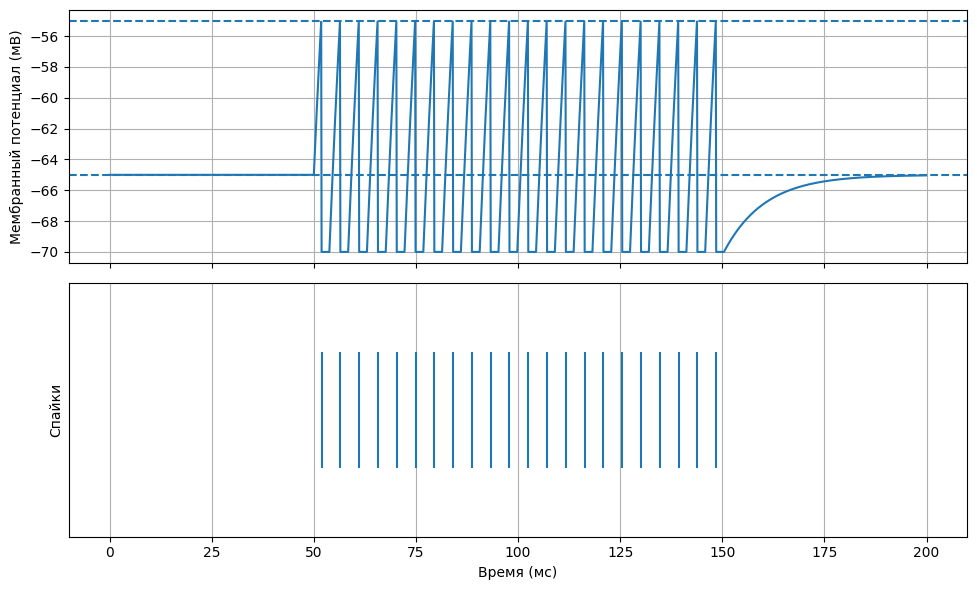

Количество спайков: 22


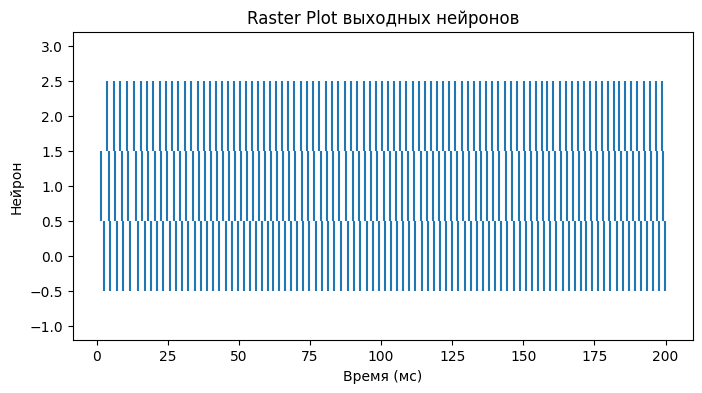

Частоты выходных нейронов: [0.46  0.46  0.455]


In [92]:
if __name__ == "__main__":

    # Параметры симуляции
    dt = 0.1
    T = 200
    t_range = np.arange(0, T, dt)

    n_inputs = 5
    n_outputs = 3


    # Создаем нейрон
    neuron = LIFNeuron()
    layer = SNNLayer(n_inputs, n_outputs)

    # Разные типы входного тока
    I_inj = np.zeros_like(t_range)
    I_inj[(t_range > 50) & (t_range < 150)] = 3.0  # ступенька

    # Симуляция
    v_trace, spike_times = simulate_neuron(
        neuron,
        I_inj,
        t_range,
        dt
    )

    # Визуализация
    plot_neuron_activity(
        t_range,
        v_trace,
        spike_times,
        neuron.v_thresh,
        neuron.v_rest
    )

    print(f"Количество спайков: {len(spike_times)}")


    # Частоты входных нейронов (разные уровни активации)
    input_rates = np.array([100, 150, 200, 250, 300]) / 1000.0 # спайки/мс

    spike_record, weight_history = simulate_network(layer, input_rates, T, dt)

    # Визуализация raster plot
    plt.figure(figsize=(8, 4))

    for neuron_id, spikes in enumerate(spike_record):
        plt.eventplot(spikes, lineoffsets=neuron_id)

    plt.xlabel("Время (мс)")
    plt.ylabel("Нейрон")
    plt.title("Raster Plot выходных нейронов")
    plt.show()

    # Подсчет частоты
    firing_rates = np.array([
        len(spikes) / T
        for spikes in spike_record
    ])

    print("Частоты выходных нейронов:", firing_rates)


    

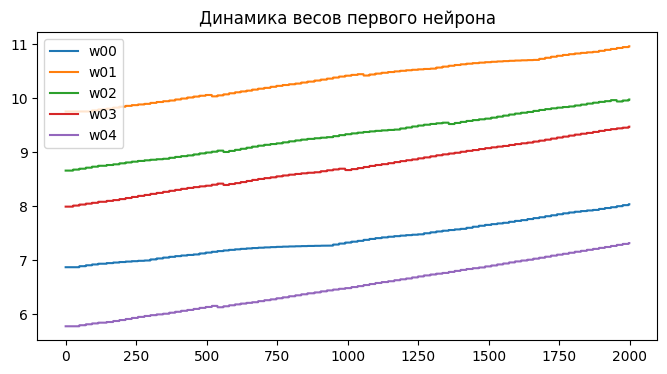

In [93]:
plt.figure(figsize=(8, 4))
for i in range(n_inputs):
    plt.plot(weight_history[:, 0, i], label=f"w0{i}")
plt.legend()
plt.title("Динамика весов первого нейрона")
plt.show()

**Создание паттернов**

In [94]:
def generate_pattern(class_id: int, high_rate=300, low_rate=20):

    rates = np.ones(5) * low_rate

    if class_id == 0:
        rates[0] = high_rate
        rates[1] = high_rate
    else:
        rates[3] = high_rate
        rates[4] = high_rate

    return rates / 1000.0

**Обучение**

In [95]:
def train(layer, n_epochs=300):

    dt = 0.1
    T = 200

    for epoch in range(n_epochs):

        class_id = np.random.randint(0, 2)
        input_rates = generate_pattern(class_id)

        simulate_network(layer, input_rates, T, dt)

In [96]:
def assign_labels(layer):

    responses = []

    for class_id in [0, 1]:
        input_rates = generate_pattern(class_id)
        spike_record, _ = simulate_network(layer, input_rates, 200, 0.1)

        firing_rates = np.array([len(s)/200 for s in spike_record])
        responses.append(firing_rates)

    responses = np.array(responses)

    labels = np.argmax(responses, axis=0)

    return labels

In [97]:
def test(layer, labels, n_tests=200):

    correct = 0

    for _ in range(n_tests):

        true_class = np.random.randint(0, 2)
        input_rates = generate_pattern(true_class)

        spike_record, _ = simulate_network(layer, input_rates, 200, 0.1)

        firing_rates = np.array([len(s)/200 for s in spike_record])

        predicted_neuron = np.argmax(firing_rates)
        predicted_class = labels[predicted_neuron]

        if predicted_class == true_class:
            correct += 1

    return correct / n_tests

In [98]:
def plot_weight_matrix(layer):
    """Визуализация матрицы весов (Heatmap)"""
    plt.figure(figsize=(6, 5))
    plt.imshow(layer.weights, aspect='auto', cmap='viridis')
    plt.colorbar(label='Сила веса')
    plt.xlabel('Входные синапсы')
    plt.ylabel('Выходные нейроны')
    plt.title('Итоговая матрица весов (Специализация нейронов)')
    plt.xticks(range(layer.n_inputs))
    plt.yticks(range(layer.n_neurons))
    plt.show()

def plot_class_responses(layer):
    """Визуализация отклика нейронов на разные классы"""
    responses = []
    for class_id in [0, 1]:
        input_rates = generate_pattern(class_id)
        spike_record, _ = simulate_network(layer, input_rates, 200, 0.1)
        firing_rates = [len(s) for s in spike_record]
        responses.append(firing_rates)
    
    responses = np.array(responses)
    
    fig, ax = plt.subplots(figsize=(7, 4))
    x = np.arange(layer.n_neurons)
    ax.bar(x - 0.2, responses[0], 0.4, label='Класс 0')
    ax.bar(x + 0.2, responses[1], 0.4, label='Класс 1')
    ax.set_ylabel('Кол-во спайков за симуляцию')
    ax.set_xlabel('ID нейрона')
    ax.set_title('Отклик нейронов на разные входные паттерны')
    ax.legend()
    plt.show()



ОБУЧЕНИЕ


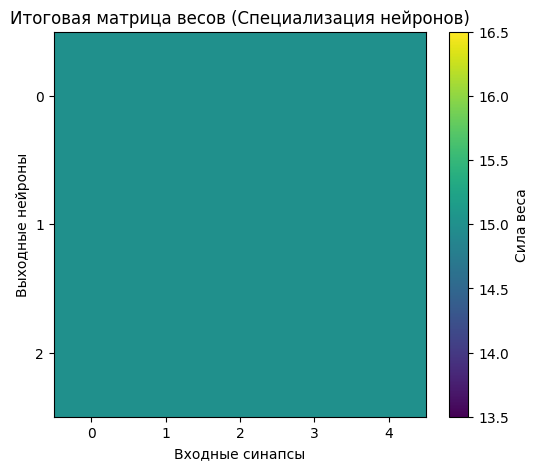

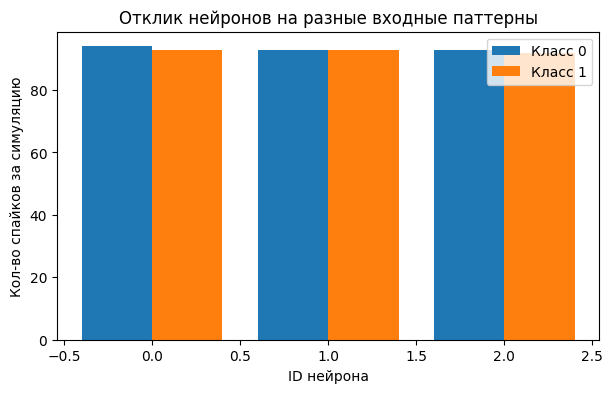


Назначение меток
Назначенные классы нейронам: [0 0 0]

ТЕСТ
Точность классификации: 0.495


In [99]:

print("\nОБУЧЕНИЕ")
train(layer, n_epochs=600)

plot_weight_matrix(layer)

plot_class_responses(layer)

print("\nНазначение меток")
labels = assign_labels(layer)
print("Назначенные классы нейронам:", labels)

print("\nТЕСТ")
accuracy = test(layer, labels, n_tests=400)
print("Точность классификации:", accuracy)

In [100]:
def simulate_network_with_noise(layer, input_rates, T, dt, noise_level=0.0):
    """
    Симуляция сети с добавлением шума во входные спайки.
    
    Параметры:
    - noise_level: вероятность инвертирования входного спайка (0 = нет шума, 1 = максимальный шум)
    """
    t_range = np.arange(0, T, dt)
    layer.reset()
    
    spike_record = [[] for _ in range(layer.n_neurons)]
    weight_history = []
    
    for t in t_range:
        # Генерируем исходные спайки на основе частот
        base_spikes = np.array([
            poisson_encoding(rate, dt)
            for rate in input_rates
        ])
        
        # Добавляем шум: с вероятностью noise_level инвертируем каждый спайк
        if noise_level > 0:
            noise_mask = np.random.random(layer.n_inputs) < noise_level
            input_spikes = np.where(noise_mask, 1 - base_spikes, base_spikes)
        else:
            input_spikes = base_spikes
        
        output_spikes = layer.step(input_spikes, dt, t)
        weight_history.append(layer.weights.copy())
        
        for j in range(layer.n_neurons):
            if output_spikes[j] == 1:
                spike_record[j].append(t)
    
    return spike_record, np.array(weight_history)


def test_with_T(layer, labels, T, n_tests=100):
    """
    Тестирование точности при разной длительности стимула.
    """
    correct = 0
    
    for _ in range(n_tests):
        true_class = np.random.randint(0, 2)
        input_rates = generate_pattern(true_class)
        
        spike_record, _ = simulate_network(layer, input_rates, T, dt=0.1)
        
        firing_rates = np.array([len(s)/T for s in spike_record])
        
        if len(firing_rates) > 0:
            predicted_neuron = np.argmax(firing_rates)
            predicted_class = labels[predicted_neuron]
            
            if predicted_class == true_class:
                correct += 1
    
    accuracy = correct / n_tests if n_tests > 0 else 0
    return accuracy

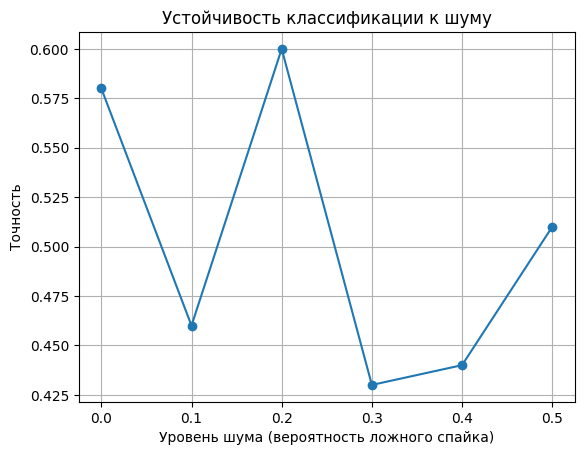

In [101]:
def test_with_noise(layer, labels, noise_levels, n_tests=100):
    accuracies = []
    for noise in noise_levels:
        correct = 0
        for _ in range(n_tests):
            true_class = np.random.randint(0, 2)
            input_rates = generate_pattern(true_class)
            # Модифицируем симуляцию, добавляя шум в спайки
            spike_record, _ = simulate_network_with_noise(layer, input_rates, T=200, dt=0.1, noise_level=noise)
            firing_rates = np.array([len(s)/200 for s in spike_record])
            predicted_neuron = np.argmax(firing_rates)
            predicted_class = labels[predicted_neuron]
            if predicted_class == true_class:
                correct += 1
        accuracies.append(correct / n_tests)
    return accuracies

# Построение графика
noise_levels = np.linspace(0, 0.5, 6)
acc = test_with_noise(layer, labels, noise_levels)
plt.plot(noise_levels, acc, marker='o')
plt.xlabel('Уровень шума (вероятность ложного спайка)')
plt.ylabel('Точность')
plt.title('Устойчивость классификации к шуму')
plt.grid()
plt.show()



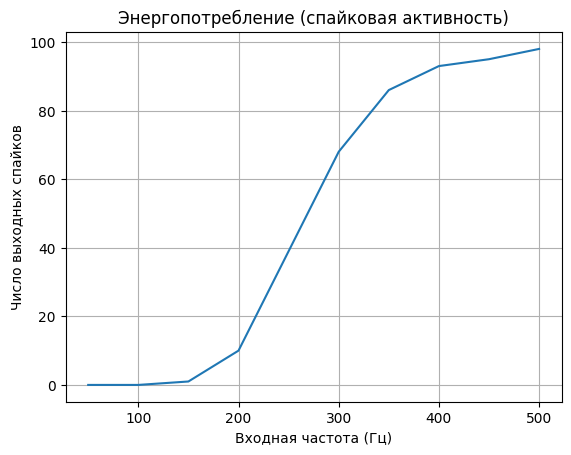

In [102]:
def count_spikes_in_simulation(layer, input_rates, T, dt):
    # Запускаем симуляцию и считаем входные и выходные спайки
    spike_record, _ = simulate_network(layer, input_rates, T, dt)
    input_spikes_total = 0  # можно собрать в simulate_network, если возвращать input_spikes_history
    output_spikes_total = sum(len(s) for s in spike_record)
    return output_spikes_total

# Пример: зависимость числа спайков от амплитуды входного тока (через частоту)
rates_range = np.linspace(50, 500, 10) / 1000
spike_counts = []
for rate in rates_range:
    input_rates = np.full(5, rate)
    count = count_spikes_in_simulation(layer, input_rates, T=200, dt=0.1)
    spike_counts.append(count)

plt.plot(rates_range*1000, spike_counts)
plt.xlabel('Входная частота (Гц)')
plt.ylabel('Число выходных спайков')
plt.title('Энергопотребление (спайковая активность)')
plt.grid()
plt.show()

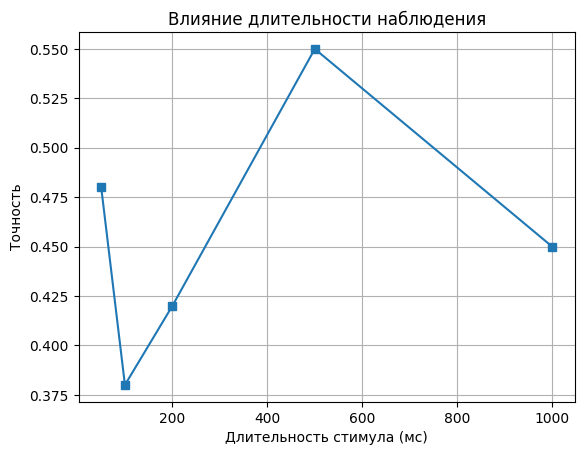

In [103]:
T_values = [50, 100, 200, 500, 1000]
acc_vs_T = []
for T in T_values:
    spike_record, _ = simulate_network(layer, input_rates, T, dt=0.1)
    firing_rates = np.array([len(s)/T for s in spike_record])
    predicted_neuron = np.argmax(firing_rates)
    predicted_class = labels[predicted_neuron]
    # Здесь нужно усреднить по многим тестам, аналогично функции test
    # Для простоты можно вставить цикл по тестам
    acc = test_with_T(layer, labels, T, n_tests=100)  # предварительно определив такую функцию
    acc_vs_T.append(acc)

plt.plot(T_values, acc_vs_T, marker='s')
plt.xlabel('Длительность стимула (мс)')
plt.ylabel('Точность')
plt.title('Влияние длительности наблюдения')
plt.grid()
plt.show()